In [ ]:
# pacotes

import requests
import pandas as pd
import json as json
import psycopg2
from sqlalchemy import create_engine, MetaData
from sqlalchemy.dialects.postgresql import insert
from urllib.parse import quote_plus
from dotenv import load_dotenv
import os
import numpy as np
import unicodedata
import re

In [ ]:
# Caminho para o .env 

dotenv_path = "URL"

# Carrega as variáveis do arquivo .env, forçando substituição se já houver algo na memória
load_dotenv(dotenv_path, override=True)

# Recupera variáveis de ambiente
host = os.getenv("host")
porta = os.getenv("porta")
usuario = os.getenv("usuario")
senha = quote_plus(os.getenv("senha"))  # Protege caracteres especiais
banco = os.getenv("database")

# Mostra para confirmação
print("Conectando em:", host, porta, usuario, banco)

# Cria a engine
engine = create_engine(f"postgresql://{usuario}:{senha}@{host}:{porta}/{banco}")

In [ ]:
# Carrega o arquivo com as credencial

with open('CREDENCIAIS') as f:
    config = json.load(f)

token = config['TOKEN_API']

In [ ]:
# API pra mostrar a lista de produtos

pagina = 1
todos_dados = []

# Loop de paginação
while True:
    url = f"API/PRODUTOS"
    headers = {
        "Content-Type": "application/json",
        "Token": token
    }

    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        dados = response.json()
        
        # Se a resposta vier vazia, terminamos a coleta
        if not dados:
            break

        todos_dados.extend(dados)
        print(f"✅ Página {pagina} carregada. Total acumulado: {len(todos_dados)}")
        pagina += 1
    else:
        print(f"❌ Erro na página {pagina}: {response.status_code} - {response.text}")
        break

# Converter em DataFrame
df_produtos = pd.DataFrame(todos_dados)

# Visualizar
print("Primeiras ordens de produção:")
print(df_produtos.head())

In [ ]:
# API OP

pagina_op = 1
todos_dados_op = []

# Loop de paginação
while True:
    url_op = f"API/OP"
    headers_op = {
        "Content-Type": "application/json",
        "Token": token
    }

    response_op = requests.get(url_op, headers=headers_op)
    
    if response_op.status_code == 200:
        dados_op = response_op.json()
        
        # Se a resposta vier vazia, terminamos a coleta
        if not dados_op:
            break

        todos_dados_op.extend(dados_op)
        print(f"✅ Página {pagina_op} carregada. Total acumulado: {len(todos_dados_op)}")
        pagina_op += 1
    else:
        print(f"❌ Erro na página {pagina_op}: {response_op.status_code} - {response_op.text}")
        break

# Converter em DataFrame
df_ops = pd.DataFrame(todos_dados_op)

# Visualizar
print("🔍 Primeiras ordens de produção:")
print(df_ops.head())

In [ ]:
# visualizando o df de OP

df_ops.head()

No retorno da API de OP temos uma coluna com formato de array, por isso no código abaixo fizemos uma transformação pra deixar tudo em formato tabular. Ex:

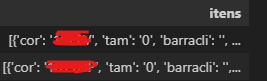

In [ ]:
# Quebrando o array dos ITENS 

# Explodir para transformar listas de dicionários em múltiplas linhas
df_explodido = df_ops.explode('itens').reset_index(drop=True)

# Normalizar os dicionários (cada chave vira uma coluna)
df_itens = pd.json_normalize(df_explodido['itens'])

# Concatenar com os dados da OP (sem a coluna original 'itens')
df_op_itens = pd.concat([df_explodido.drop(columns=['itens']), df_itens], axis=1)

Vou criar uma segunda coluna com o codigo do produto e uma segunda coluna com a cor. Com isso, vamos deixar elas sem caracteres especiais e vamos criar uma chave

In [ ]:
df_op_itens.head()

Na coluna de "cor" existe um padrão de "[" antes e depois do nome, no código abaixo normalizamos isso

In [ ]:
# Tirar os [] que estão na coluna de cor

# Garantir que a coluna seja string e remover colchetes + transformar em lista
df_produtos['cor'] = df_produtos['cor'].astype(str).str.strip('[]').str.split(',')

# Explodir a coluna em várias linhas
df_produtos = df_produtos.explode('cor')

# Limpar espaços e remover caracteres especiais da coluna 'codigoCor'
df_produtos['cor'] = df_produtos['cor'].str.strip()
df_produtos['cor'] = df_produtos['cor'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

# Visualizar resultado final
df_produtos.reset_index(drop=True, inplace=True)
display(df_produtos.head(5))

In [ ]:
df_produtos.columns

In [ ]:
# Função pra tirar os caracteres especiais das colunas de codigo e cor

def normalizar_texto(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.strip().upper()
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')
    texto = re.sub(r'[^A-Z0-9]', '', texto)  # mantém apenas letras e números
    return texto

def limpar_coluna_texto(df, nome_coluna):
    df[nome_coluna] = df[nome_coluna].apply(normalizar_texto)
    return df

In [ ]:
df_produtos.head(1)

In [ ]:
# Cria uma segunda coluna com o codigo do produto e uma segunda coluna com a cor e depois cria a chave na df produtos

df_produtos ['codigo2'] = df_produtos ['codigo']
df_produtos ['cor2'] = df_produtos ['cor']

# aplica a funcao
df_produtos = limpar_coluna_texto(df_produtos, 'codigo2')
df_produtos = limpar_coluna_texto(df_produtos, 'cor2')

# cria a chave
df_produtos ['chave_produto_cor'] = df_produtos ['codigo2'] + "-" + df_produtos ['cor2']

In [ ]:
df_produtos.head()

In [ ]:
# Cria uma segunda coluna com o codigo do produto e uma segunda coluna com a cor e depois cria a chave na df produtos

df_op_itens ['codigo2'] = df_op_itens ['codigo']
df_op_itens ['cor2'] = df_op_itens ['cor']

# aplica a funcao
df_op_itens = limpar_coluna_texto(df_op_itens, 'codigo2')
df_op_itens = limpar_coluna_texto(df_op_itens, 'cor2')

# cria a chave
df_op_itens ['chave_produto_cor'] = df_op_itens ['codigo2'] + "-" + df_op_itens ['cor2']

In [ ]:
df_op_itens.head()

In [ ]:
# mantém somente as colunas interessantes para análises posteriores

df_produtos = df_produtos [['data_cad','codigo','descricao','unidade','grupo','linha','familia','status','espessura','peso','marca','preco_tabela','custo','cor','chave_produto_cor']]
df_produtos.head()

In [ ]:
# rename

df_produtos.rename(columns={
    'descricao':'nome',
    'preco_tabela':'preco',
    'cor':'codigoCor'
},inplace=True)

df_produtos.columns

In [ ]:
# transforma pra datetime pra nao dar erro na carga

df_produtos ['data_cad'] = pd.to_datetime(df_produtos['data_cad'])

Antes de salvar os dados no banco, vamos precisar fazer uma validação para verificar se todos os produtos que estão na tabela de OP também estão na tabela de PRODUTOS. 

In [ ]:
# Lista de chaves da tabela de produtos
lista_chaves_produtos = df_produtos['chave_produto_cor'].tolist()

# Verifica se a chave da OP está presente na tabela de produtos
df_op_itens['flag_validacao'] = df_op_itens['chave_produto_cor'].isin(lista_chaves_produtos).astype(int)

# Filtra os que não foram encontrados
df_produtos_faltantes = df_op_itens.query("flag_validacao == 0")

# Lista de chaves e códigos faltantes
lista_chaves_faltantes = df_produtos_faltantes['chave_produto_cor'].drop_duplicates().tolist()
lista_codigos_faltantes = df_produtos_faltantes['codigo'].drop_duplicates().tolist()

In [ ]:
lista_chaves_faltantes

In [ ]:
df_produtos.head()

In [ ]:
# Colunas do DataFrame original
colunas = df_produtos.columns.tolist()

# Colunas por tipo (baseado no banco)
colunas_numericas = ['espessura', 'peso', 'preco', 'custo']
colunas_data = ['data_cad']
colunas_texto = [col for col in colunas if col not in colunas_numericas + colunas_data + ['codigo']]

# Construção dos novos produtos
dados_novos_produtos = []

for codigo, chave in zip(lista_codigos_faltantes, lista_chaves_faltantes):
    produto_dict = {}
    for col in colunas:
        if col == 'codigo':
            produto_dict[col] = codigo
        elif col == 'chave_produto_cor':
            produto_dict[col] = chave
        elif col in colunas_numericas:
            produto_dict[col] = np.nan
        elif col in colunas_data:
            produto_dict[col] = pd.NaT
        else:
            produto_dict[col] = "Não Identificado"
    dados_novos_produtos.append(produto_dict)


# Cria e concatena ao DataFrame original
novosprodutos = pd.DataFrame(dados_novos_produtos)
df_produtos = pd.concat([df_produtos, novosprodutos[df_produtos.columns]], ignore_index=True)

print(f"✅ Produtos adicionados: {len(novosprodutos)}")

In [ ]:
df_produtos.head()

In [ ]:
df_produtos.dtypes

In [ ]:
# Reflete a estrutura do banco para capturar a tabela já existente
metadata = MetaData()
metadata.reflect(bind=engine)
tabela_produtos = metadata.tables["Produto"]

# Remove duplicatas pela chave primária para evitar erro de UNIQUE
df_produtos = df_produtos.drop_duplicates(subset=["chave_produto_cor"])

# Converte todos os valores nulos para None
df_produtos = df_produtos.replace({pd.NaT: None, np.nan: None}).where(pd.notnull(df_produtos), None)

# Converte DataFrame para lista de dicionários
dados = df_produtos.to_dict(orient="records")

# Cria comando de insert com tratamento de conflito (modo incremental)
stmt = insert(tabela_produtos).values(dados)
stmt = stmt.on_conflict_do_nothing(index_elements=["chave_produto_cor"])

# Executa apenas inserção incremental (sem apagar dados existentes)
with engine.begin() as conn:
    conn.execute(stmt)